In [1]:
#!pip install seaborn

In [60]:
import numpy as np
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
import xgboost as xgb
from sklearn.svm import SVC
#from imblearn.over_sampling import SMOTE
#from imblearn.pipeline import Pipeline  

In [34]:
test = pd.read_csv('Additional_test.csv')
train = pd.read_csv('Additional_train.csv')
X = train.drop(columns=['DefaultLabel','CustomerID','Week','Utilisation', 'HardInquiries', 'NumChecking', 'Tenure', 'payment_ratio_change', 'credit_utilization_change', 'utilization_trend',  'HomeCity', 'is_rapid_credit_growth', 'is_high_utilization'])
Y = train['DefaultLabel']

In [11]:
# X_train, X_valid, Y_train, Y_valid = train_test_split(X,Y,test_size=0.2,random_state=42,stratify=Y)

<Axes: >

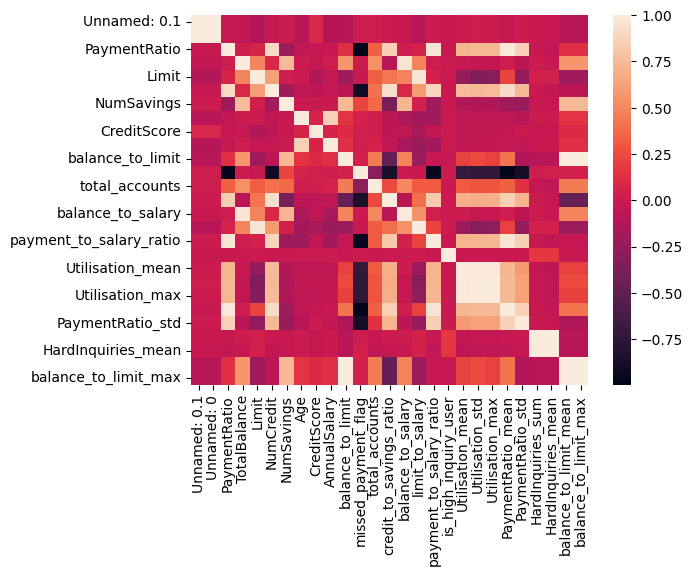

In [35]:
#Mutual Information/ Information Gain for C2
#Correlation Matrix
train_corr = X.corr()
sns.heatmap(train_corr)

In [47]:
# for name, model in models.items():
#     pipeline = Pipeline([
#         ('imputer', imputer),
#         ('scaler', StandardScaler()),
#         ('model', model)
#     ])
    
#     scores = cross_validate(pipeline, X, Y, cv=cv, scoring=scoring)
#     mean_scores = pd.DataFrame(scores).mean()[['test_recall','test_precision','test_f1']]
#     mean_scores['model'] = name
#     results = []
#     results.append(mean_scores)
#     results_df = pd.DataFrame(results).set_index('model')
#     print(results_df.sort_values('test_f1', ascending=False))

           test_recall  test_precision   test_f1
model                                           
LogReg_L1     0.873527        0.686471  0.727451
           test_recall  test_precision   test_f1
model                                           
LogReg_L2     0.873444        0.686336  0.727271
              test_recall  test_precision   test_f1
model                                              
RandomForest     0.958095        0.878394  0.913139
       test_recall  test_precision   test_f1
model                                       
SVM       0.956366        0.807847  0.861724


In [47]:
imputer = SimpleImputer(strategy='median')
# smote = SMOTE(random_state=42)
model = Pipeline([('imputer',imputer),('scaler', StandardScaler()),
                  ('model', LogisticRegression(solver='liblinear',max_iter=1000,class_weight='balanced', C=5,penalty='l2',fit_intercept=True))])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'recall': make_scorer(recall_score, average='macro'),
    'precision': make_scorer(precision_score,average='macro'),
    'f1': make_scorer(f1_score,average='macro')
}
# scores = cross_validate(model,X,Y,cv=cv,scoring=scoring)
print(pd.DataFrame(scores).mean()[['test_recall', 'test_precision', 'test_f1']])

test_recall       0.747830
test_precision    0.598476
test_f1           0.596226
dtype: float64


In [48]:
# est_recall       0.873527
# test_precision    0.686471
# test_f1           0.727451
model.fit(X, Y)
X_pred = test.drop(columns=['CustomerID', 'Week','Utilisation', 'HardInquiries', 'NumChecking', 'Tenure', 'payment_ratio_change', 'credit_utilization_change', 'utilization_trend',  'HomeCity', 'is_rapid_credit_growth', 'is_high_utilization'], errors='ignore')
X_pred = X_pred[X.columns] 
predictions = model.predict(X_pred)

In [49]:
# Create submission file (format: TxnID,FraudLabel)
submission_df = pd.DataFrame({
    'CustomerID':test['CustomerID'],
    'Week': test['Week'],                   
    'DefaultLabel': predictions
})

# Save predictions
submission_df.to_csv("RB_logR_C2.csv", index=False)
print(len(X))
print(f"✅ Predictions saved: {submission_df.shape[0]} predictions")
print(f"   Preview: {submission_df.head(3)}")
print(f"   Default rate: {predictions.mean():.3f} ({predictions.sum()} default cases out of {len(predictions)})")

13301
✅ Predictions saved: 13290 predictions
   Preview:   CustomerID  Week  DefaultLabel
0    C000001     1             0
1    C000001     2             0
2    C000001     3             0
   Default rate: 0.282 (3752 fraud cases out of 13290)


In [50]:
# from sklearn.model_selection import GridSearchCV
#{'model__C': 5, 'model__class_weight': 'balanced', 'model__fit_intercept': True, 'model__penalty': 'l2', 'model__solver': 'liblinear'}

# Expanded parameter grid
param_grid = {
    'model__C': [0.01, 0.1, 5],  # wide range for regularization strength
    'model__penalty': ['l1', 'l2'],                     # both penalties compatible with liblinear
    'model__solver': ['liblinear'],                     # liblinear works with l1 and l2
    'model__fit_intercept': [True, False],              # test including/excluding intercept
    'model__class_weight': ['balanced', None]           # see if balancing helps
}

search = GridSearchCV(model, param_grid, scoring='f1_macro', cv=cv,n_jobs=-1)
search.fit(X, Y)
print(search.best_params_)

KeyboardInterrupt: 

In [46]:
from agentds import BenchmarkClient

client = BenchmarkClient(
    api_key="adsb_hdm1DRk1iW2I1VA84Oc9jz6z_1756090832",        # Get from your team dashboard
    team_name="agi"     # Your exact team name
)

# 3. Submit Predictions

# Submit predictions to the competition
print("🚀 Submitting predictions...")

try:
    result = client.submit_prediction("Retailbanking", 2, "RB_logR_C2.csv")
    
    if result['success']:
        print("✅ Submission successful!")
        print(f"   📊 Score: {result['score']:.4f}")
        print(f"   📏 Metric: {result['metric_name']}")
        print(f"   ✔️  Validation: {'Passed' if result['validation_passed'] else 'Failed'}")
    else:
        print("❌ Submission failed!")
        print(f"   Error details: {result.get('details', {}).get('validation_errors', 'Unknown error')}")
        
except Exception as e:
    print(f"💥 Submission error: {e}")
    print("🔧 Check your API key and team name are correct!")

🚀 Submitting predictions...
✅ Prediction submitted successfully!
📊 Score: 0.5685 (Macro-F1)
✅ Validation passed
✅ Submission successful!
   📊 Score: 0.5685
   📏 Metric: Macro-F1
   ✔️  Validation: Passed


In [71]:
## Stacking
bst = xgb.XGBClassifier()
base_model = [('xgboost',bst)]

In [72]:
clf_stack = StackingClassifier(estimators = base_model, final_estimator=LogisticRegression(),cv=cv)

In [74]:
clf_stack.fit(X, Y)
clf_pred = test.drop(columns=['CustomerID', 'Week','Utilisation', 'HardInquiries', 'NumChecking', 'Tenure', 'payment_ratio_change', 'credit_utilization_change', 'utilization_trend',  'HomeCity', 'is_rapid_credit_growth', 'is_high_utilization'], errors='ignore')
clf_pred = clf_pred[X.columns] 
predictions = clf_stack.predict(clf_pred)

In [75]:
# Create submission file (format: TxnID,FraudLabel)
submission_df = pd.DataFrame({
    'CustomerID':test['CustomerID'],
    'Week': test['Week'],                   
    'DefaultLabel': predictions
})

# Save predictions
submission_df.to_csv("RB_C2_stack.csv", index=False)
print(len(X))
print(f"✅ Predictions saved: {submission_df.shape[0]} predictions")
print(f"   Preview: {submission_df.head(3)}")
print(f"   Default rate: {predictions.mean():.3f} ({predictions.sum()} default cases out of {len(predictions)})")

13301
✅ Predictions saved: 13290 predictions
   Preview:   CustomerID  Week  DefaultLabel
0    C000001     1             0
1    C000001     2             0
2    C000001     3             0
   Default rate: 0.040 (525 default cases out of 13290)
